In [1]:
import numpy as np
import torch
import torchdiffeq
import matplotlib.pyplot as plt
import time

In [120]:
toy_example = False
if toy_example:
    c = torch.load('data/c.pt', weights_only=True)
    d = torch.load('data/d.pt', weights_only=True)
    A = torch.load('data/A.pt', weights_only=True)
    H = torch.load('data/H.pt', weights_only=True)

    dimX = (A.shape[0], 1);dimY = (A.shape[1], 1);
    sizeX = dimX[0] * dimX[1]; sizeY = dimY[0] * dimY[1];

    def f(x, y):
        x = x.reshape(dimX); y = y.reshape(dimY)
        return torch.sin(c.T @ x + d.T @ y) + torch.log(torch.linalg.norm(x+y)**2 + 1)

    def g(x, y):
        x = x.reshape(dimX); y = y.reshape(dimY)
        return 0.5 * torch.linalg.norm(H@y - x)**2
else:
    A_tr = torch.load('data/A_tr.pt', weights_only=True).to(torch.float32)
    B_tr = torch.load('data/B_tr.pt', weights_only=True).to(torch.float32)

    A_val = torch.load('data/A_val.pt', weights_only=True).to(torch.float32)
    B_val = torch.load('data/B_val.pt', weights_only=True).to(torch.float32)

    A_test = torch.load('data/A_test.pt', weights_only=True).to(torch.float32)
    B_test = torch.load('data/B_test.pt', weights_only=True).to(torch.float32)

    lam = 0.01      # Regularization parameter
    dimX = (A_tr.shape[0], 1); dimY = (A_tr.shape[1], B_tr.shape[1]);
    sizeX = dimX[0] * dimX[1]; sizeY = dimY[0] * dimY[1];

    n_train = A_tr.shape[0]
    n_val = A_val.shape[0]
    n_test = A_test.shape[0]


    def f(x, y):
        x = x.reshape(dimX); y = y.reshape(dimY)
        loss = 1 / n_val * torch.sum(torch.log(1 + torch.exp(-B_val * (A_val @ y))))
        return loss

    def g(x, y):
        x = x.reshape(dimX); y = y.reshape(dimY)
        return 1 / n_train * torch.sum(torch.log(1 + torch.exp(-B_tr * (A_tr @ y))) * (1 / (1 + torch.exp(-x)))) \
              + lam * torch.linalg.norm(y, 'fro')**2

print('dim X:', dimX, 'dim Y:' ,dimY)

dim X: (7000, 1) dim Y: (56, 10)


In [121]:
def calc_derivatives(x, y):
    f_val = f(x,y)
    g_val = g(x,y)

    # 1st derivatives
    dfdy = torch.autograd.grad(f_val, y, create_graph=True, allow_unused=True, materialize_grads=True)[0]
    dfdx = torch.autograd.grad(f_val, x, create_graph=True, allow_unused=True, materialize_grads=True)[0]

    dgdy = torch.autograd.grad(g_val, y, create_graph=True, allow_unused=True, materialize_grads=True)[0]
    dgdx = torch.autograd.grad(g_val, x, create_graph=True, allow_unused=True, materialize_grads=True)[0]

    # Initialize tensors for 2nd derivatives
    dgdyy = torch.zeros((sizeY, sizeY))
    dgdyx = torch.zeros((sizeY, sizeX))
    # Compute 2nd derivatives element-wise
    for i in range(dgdy.shape[0]):
        dgdyy[i, :] = torch.autograd.grad(dgdy[i], y, retain_graph=True, create_graph=True, allow_unused=True, materialize_grads=True)[0][:, 0]
        dgdyx[i, :] = torch.autograd.grad(dgdy[i], x, retain_graph=True, create_graph=True, allow_unused=True, materialize_grads=True)[0][:, 0]
    
    return dfdx, dfdy, dgdx, dgdy, dgdyy, dgdyx

def calc_derivatives_analytic(x, y):
    if toy_example:
        dfdx = torch.cos(c.T @ x + d.T @ y) * c + 2 *(x+y) / (torch.linalg.norm(x+y)**2 + 1)
        dfdy = torch.cos(c.T @ x + d.T @ y) * d + 2 * (x+y) / (torch.linalg.norm(x+y)**2 + 1)

        dgdx = - (H @ y - x)
        dgdy = H.T @ (H @ y - x)

        dgdyy = H.T @ H
        dgdyx = -H
    else:
        raise NotImplementedError
    return dfdx, dfdy, dgdx, dgdy, dgdyy, dgdyx

if toy_example: calc_derivatives = calc_derivatives_analytic

In [122]:
def solveLL(x):
    y = torch.randn((sizeY, 1), requires_grad=True, dtype=torch.float32)
    lr = 1e-1
    while True:
        dfdx, dfdy, dgdx, dgdy, dgdyy, dgdyx = calc_derivatives(x, y)
        HessianInv = dgdyy.inverse()
        if torch.linalg.norm(dgdy, 2) < 1e-3:
            break
        with torch.no_grad():
            y -= lr * HessianInv @ dgdy
    return y


# Define the system of ODEs
def system(t, variables):
    x, y = variables[:sizeX], variables[sizeX:]
    global dxdt #Because its previous value is required in ProjectMethod 1
    
    dfdx, dfdy, dgdx, dgdy, dgdyy, dgdyx = calc_derivatives(x, y)
    with torch.no_grad():    
        if method == 'InversionFree':
            a = 2 * dgdyx.T @ dgdy
            b = 2 * dgdyy @ dgdy
            c = -alpha * (torch.linalg.norm(dgdy, 2)**2 - epsilon**2)
            ab = torch.cat((a, b), 0)

            tot = torch.cat((dfdx, dfdy), 0)
            d = ab * torch.maximum(torch.Tensor([0]), -ab.T @ tot - c) / (torch.linalg.norm(a, 2)**2 + torch.linalg.norm(b, 2)**2)
            dtotdt = -tot - d
            dxdt = dtotdt[:sizeX]; dydt = dtotdt[sizeX:]
            
            if torch.linalg.norm(dgdy, 2) > epsilon and not torch.allclose(torch.linalg.norm(dgdy, 2), torch.Tensor([epsilon])):
                print('t=',t, '-', torch.linalg.norm(dgdy, 2), epsilon)
        #  
        elif method == 'NewSecondOrder':
            a = dgdyx @ dgdyx.T
            b = dgdyy @ dgdyy.T
            c = -alpha * dgdy + dgdyx @ dfdx + dgdyy @ dfdy
            lam = -torch.inverse(a + b) @ c

            dxdt = -dfdx - dgdyx.T @ lam
            dydt = -dfdy - dgdyy.T @ lam

        elif method == 'SecondOrder':
            mu = 0.05
            gHessianInv = dgdyy.inverse()
            dxdt = -dfdx + dgdyx.T @ gHessianInv @ dfdy
            dydt = -gHessianInv @ (mu * dgdy + dgdyx @ dxdt)  
        # 
        elif method == 'STABLE':
            mu1 = 1
            mu2 = 0.1
            gHessianInv = dgdyy.inverse()
            dxdt = mu1 * (-dfdx + dgdyx.T @ gHessianInv @ dfdy)
            dydt = -mu2 * dgdy - gHessianInv @ dgdyx @ dxdt 
        
        else:
            raise ValueError('Invalid method')
    
    return torch.cat((dxdt, dydt), 0)

In [123]:
def plot_metrics(solution, t, axs, figs, info):
    ax1, ax2 = axs
    fig1, fig2 = figs

    # Helper function to calculate accuracy
    def calculate_accuracy(A, B, W):
        W = W.reshape(dimY, -1)  # Reshape W to be of shape (num_classes, num_features)
        predictions = A @ W  # (n_samples, num_classes)
        predicted_labels = torch.argmax(predictions, dim=1)
        true_labels = torch.argmax(B, dim=1)  # Convert one-hot to class indices
        correct_predictions = (predicted_labels == true_labels).float().sum()
        return correct_predictions / B.size(0)

    # Helper function to calculate loss
    def calculate_loss(A, B, W, n_samples):
        W = W.reshape(dimY, -1)  # Reshape W to be of shape (num_classes, num_features)
        logits = A @ W  # (n_samples, num_classes)
        true_labels = torch.argmax(B, dim=1)  # Convert one-hot to class indices
        loss = torch.nn.functional.cross_entropy(logits, true_labels, reduction='mean')
        return loss.unsqueeze(0).unsqueeze(0)

    # Lists to store metrics
    train_accuracy, val_accuracy, test_accuracy = [], [], []
    train_loss, val_loss, test_loss = [], [], []

    # Calculate metrics for each solution
    with torch.no_grad():
        for i in range(len(solution)):
            W = solution[i, sizeX:]

            # Train accuracy and loss
            train_accuracy.append(calculate_accuracy(A_tr, B_tr, W))
            train_loss.append(calculate_loss(A_tr, B_tr, W, n_train))

            # Validation accuracy and loss
            val_accuracy.append(calculate_accuracy(A_val, B_val, W))
            val_loss.append(calculate_loss(A_val, B_val, W, n_val))

            # Test accuracy and loss
            test_accuracy.append(calculate_accuracy(A_test, B_test, W))
            test_loss.append(calculate_loss(A_test, B_test, W, n_test))

        # Plotting accuracy
        ax1.plot(t, test_accuracy, label='Test Accuracy' + (info))
        ax1.set_xlabel('time', fontsize=14)
        ax1.set_ylabel('Accuracy', fontsize=14)
        ax1.legend()

        # Plotting loss
        # ax2.plot(t, train_loss, label='Train')
        ax2.plot(t, val_loss, label='Validation')
        ax2.set_xlabel('time', fontsize=14)
        ax2.set_ylabel('Loss', fontsize=14)
        ax2.legend()

        fig1.savefig('Result/' + ('toy_example/' if toy_example else 'DHC/') + 'Acc' + '.pdf', dpi=300)
        fig2.savefig('Result/' + ('toy_example/' if toy_example else 'DHC/') + 'Loss' + '.pdf', dpi=300)
   
        
def plot_results(solutions, scenarios, axs, figs, t):
    plt.rcParams.update({'font.size': 13})

    if toy_example:
        fig1, fig11, fig2 = figs
        ax1, ax11, ax2 = axs
    else:
        fig1, fig11, fig2, fig3, fig4 = figs
        ax1, ax11, ax2, ax3, ax4 = axs
    
    flag_method, flag_alpha, flag_epsilon = 1, 1, 1
    try:
        if scenarios[0][0] == scenarios[1][0]: flag_method = 0
        if scenarios[0][1] == scenarios[1][1]: flag_alpha = 0
        if scenarios[0][2] == scenarios[1][2]: flag_epsilon = 0
    except:
        flag_alpha, flag_epsilon = 0, 0

    for (solution, scenario) in zip(solutions, scenarios):
        method, alpha, epsilon = scenario
        lossF, lossG, lossF2 = [], [], []
        for i in range(len(solution)):
            lossF.append(f(solution[i, :sizeX], solution[i, sizeX:]).detach().numpy().reshape(-1))
            dfdx, dfdy, dgdx, dgdy, dgdyy, dgdyx = calc_derivatives(solution[i, :sizeX], solution[i, sizeX:])
            lossG.append(torch.linalg.norm(dgdy).detach().numpy())
            lossF2.append(torch.linalg.norm(dfdx - dgdyx.T @ dgdyy.inverse() @ dfdy).detach().numpy())


        strLabel = ((r': $\alpha$= ' + str(alpha)) if flag_alpha else r': $\varepsilon$= ' + str(epsilon) if method == 'InversionFree' else '')
        ax1.plot(t, lossF, label= (method + strLabel))
        ax11.plot(t, lossF2, label=(method + strLabel))
        
        # -----------------------------------------------------
        ax2.plot(t, lossG, label=(method + strLabel))
        ax2.plot(t, [epsilon] * len(t), 'r--')

        if not toy_example: plot_metrics(solution, t, [ax3, ax4], [fig3, fig4], method + strLabel);


    ax1.legend()
    ax1.set_xlabel('time', fontsize=14)
    ax1.set_ylabel('f(x,y)', fontsize=14)

    ax11.legend()
    ax11.set_xlabel('time', fontsize=14)
    ax11.set_ylabel(r'$\|\nabla F(x,y)\|$', fontsize=14)
    ax11.set_yscale('log')

    ax2.legend()
    ax2.set_xlabel('time', fontsize=14)
    ax2.set_ylabel(r'$\|\nabla g(x,y)\|$', fontsize=14)
    # ax2.set_ylim([0, 1.25 * epsilon])


    # plt.tight_layout()
    scenarioItems = ['method', 'alpha', 'epsilon']
    item = 2 * flag_epsilon + 1 * flag_alpha + 0 * flag_method
    fig1.savefig('Result/' + ('toy_example/' if toy_example else 'DHC/') + scenarioItems[item] + ':' + str(scenarios[0][item]) + '-up1' + '.pdf', dpi=300)
    fig11.savefig('Result/' + ('toy_example/' if toy_example else 'DHC/') + scenarioItems[item] + ':' + str(scenarios[0][item]) + '-up2' + '.pdf', dpi=300)
    fig2.savefig('Result/' + ('toy_example/' if toy_example else 'DHC/') + scenarioItems[item] + ':' + str(scenarios[0][item]) + '-low' + '.pdf', dpi=300)


LL error:  tensor(0.0009, grad_fn=<AmaxBackward0>)
-- Method: InversionFree Alpha: 0.1 Epsilon: 0.5
Time taken: 21.907878398895264


/home/sina/.local/lib/python3.10/site-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/home/sina/.local/lib/python3.10/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


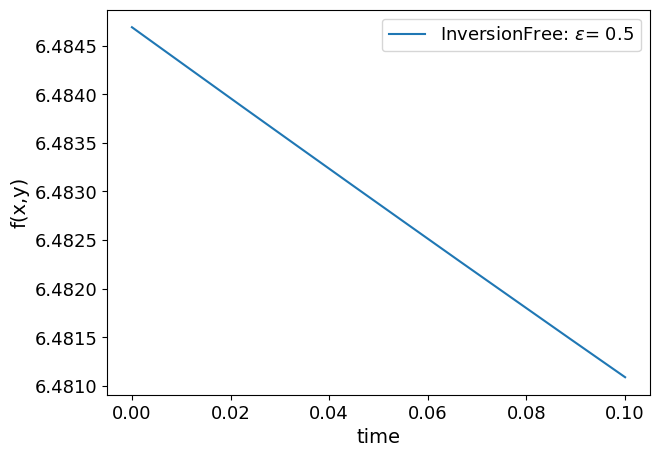

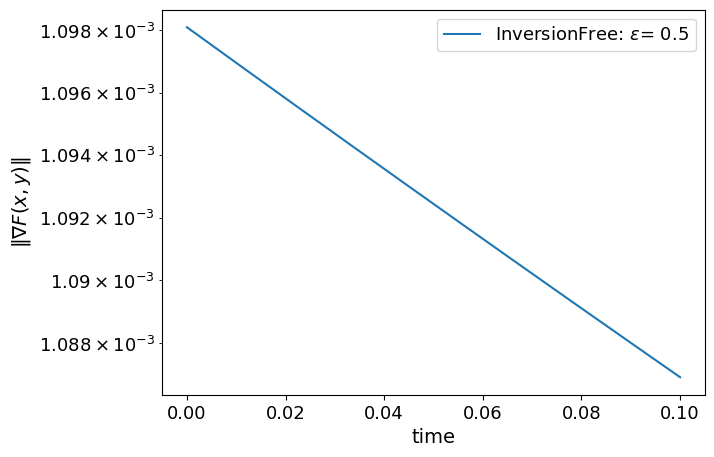

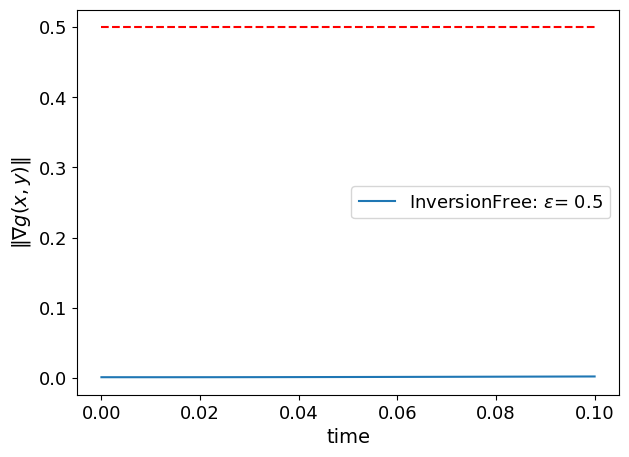

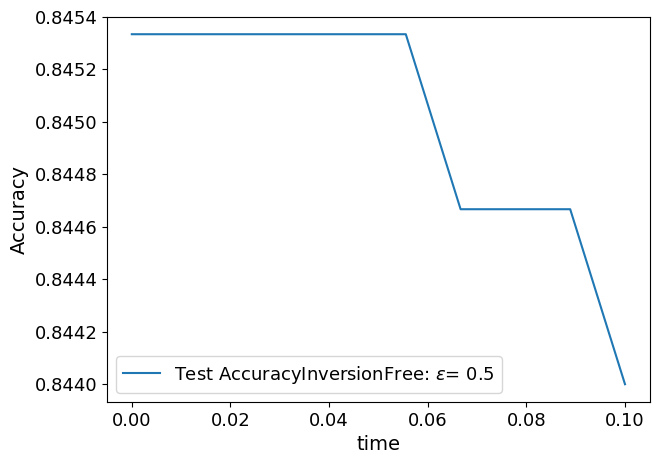

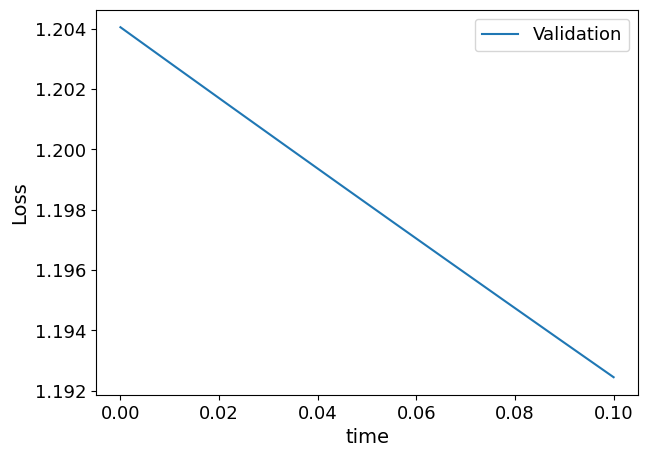

: 

In [124]:
fig1, ax1 = plt.subplots(1, 1, figsize=(7, 5))
fig11, ax11 = plt.subplots(1, 1, figsize=(7, 5))
fig2, ax2 = plt.subplots(1, 1, figsize=(7, 5))
if not toy_example:
    fig3, ax3 = plt.subplots(1, 1, figsize=(7, 5))
    fig4, ax4 = plt.subplots(1, 1, figsize=(7, 5))
    axs = [ax1, ax11, ax2, ax3, ax4]
    figs = [fig1, fig11, fig2, fig3, fig4]
else:
    axs = [ax1, ax11, ax2]
    figs = [fig1, fig11, fig2]

scenarioAlpha = [('InversionFree', 0.01, 0.1), ('InversionFree', 0.05, 0.1), ('InversionFree', 0.1, 0.1), ('InversionFree', 0.5, 0.1), ('InversionFree', 1, 0.1)]
scenarioEps = [('InversionFree', 0.1, 0.05), ('InversionFree', 0.1, 0.1), ('InversionFree', 0.1, 0.5), ('InversionFree', 0.1, 1)]
scenario2nd = [('SecondOrder', 0.1, 0.1), ('NewSecondOrder', 0.1, 0.1), ('InversionFree', 0.1, 0.1)]
scenarioDHC = [('SecondOrder', 0.1, 0.5), ('InversionFree', 0.1, 0.5)]
scenarioTest = [('InversionFree', 0.1, 0.5)]
# 
scenarios = scenarioTest
solutions = []
torch.manual_seed(0)
# x = torch.randn((sizeX, 1), requires_grad=True, dtype=torch.float32)
x = torch.ones((sizeX, 1), requires_grad=True, dtype=torch.float32)
# y0 = torch.randn((sizeY, 1), requires_grad=True, dtype=torch.float32)
y0 = solveLL(x)
dfdx, dfdy, dgdx, dgdy, dgdyy, dgdyx = calc_derivatives(x, y0)
print('LL error: ', torch.linalg.norm(dgdy, 2))
if toy_example:
    t = torch.linspace(0, 100, 10000)
else:
    t = torch.linspace(0, 0.1, 10)

for (method, alpha, epsilon) in scenarios:
    print('-- Method:', method, 'Alpha:', alpha, 'Epsilon:', epsilon)
    initial_conditions = torch.cat((x, y0), 0)
    dxdt = torch.zeros((sizeX, 1))
    t1 = time.time()
    solution = torchdiffeq.odeint(system, initial_conditions, t, method='rk4')
    print('Time taken:', time.time() - t1)
    solutions.append(solution)

plot_results(solutions, scenarios, axs, figs, t)